In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.neighbors import KernelDensity  # kernel density estimation
from mpmath import jtheta  # jacobi elliptic theta function
import multiprocessing
from sbpy.data import Names

Import list of all minor planets from the MPC `MPCORB` `.json` file so we can use the same data set as Granvik 2016, 2017, 2018:

Note that the `.json` file needs to be gotten from the MPC for local use.

In [2]:
# list of all minor planets from the MPC:
all_mps = pd.read_json('mpcorb_extended.json')

Import list of all comets from the MPC as well for completeness:

In [3]:
comet_colspecs = [(0, 4), (4, 5), (5, 12), (14, 18), (19, 21), (22, 29), (30, 39), (41, 49), (51, 59), (61, 69), 
                  (71, 79), (81, 85), (85, 87), 
                  (87, 89), (91, 95), (96, 100), (102, 158), (159, 168)]

all_comets = pd.read_fwf('CometEls.txt', colspecs=comet_colspecs, header=None)
# columns
# orbit format is https://www.minorplanetcenter.net/iau/info/CometOrbitFormat.html
all_comets.columns = ['number', 'orbit_type', 'prov_desig', 'year', 'month', 'day', 
                      'q', 'e', 'arg_peri', 'node', 'inc', 
                      'year_epoch', 'month_epoch', 'day_epoch', 'H', 'slope', 'designation', 'reference']
all_comets['H'] = pd.to_numeric(all_comets.H, errors='coerce')

Read in all the `.csv` files containing all numbered and unnumbered minor planets, as well as comets, observed by either `G96` or `703` (CSS) between $2005$ and $2012$. These are generated by processing the `NumObs.txt`, `UnnObs.txt` and `CmtObs.txt` files from the MPC with the `mpc_process.py`, `mpc_process_unn.py` and `mpc_process_cmt.py` scripts, respectively.

In [4]:
all_css_num_mpcs = set()
all_css_unn_mpcs = set()
# two sets for the comets, one for those identified by number and one for those identified by provisional designation
all_css_cmts_numbered = set()
all_css_cmts_prov_desig = set()

# read in files in a loop
for i in tqdm(range(0, 426)):
    # processed_num_csv = pd.read_csv(f'mpc_data_num/mpc_processed_num_{i}.csv')
    # all_css_num_mpcs.update(processed_num_csv.packed_number)
    processed_num_csv = pd.read_csv(f'mpc_data_num/mpc_processed_{i}.csv')
    all_css_num_mpcs.update(processed_num_csv.packed_desig)

for j in tqdm(range(0, 36)):
    processed_unn_csv = pd.read_csv(f'mpc_data_unn/mpc_processed_unn_{j}.csv')
    all_css_unn_mpcs.update(processed_unn_csv.packed_desig)

for k in tqdm(range(0, 2)):
    processed_cmt_csv = pd.read_csv(f'mpc_data_cmt/mpc_processed_cmt_{k}.csv')
    all_css_cmts_numbered.update(processed_cmt_csv.number.dropna())
    all_css_cmts_prov_desig.update(processed_cmt_csv.provisional_desig.dropna())

# convert from packed to unpacked format
unpacked_css_num_mpcs = [Names.from_packed(str(mp)) for mp in list(all_css_num_mpcs)]
unpacked_css_unn_mpcs = [Names.from_packed(str(mp.rstrip('*'))) for mp in list(all_css_unn_mpcs)]  # strip asterisk if it's there
unpacked_css_cmts_numbered = [Names.from_packed(str(cmt)) for cmt in list(all_css_cmts_numbered)]
unpacked_css_cmts_prov_desig = [Names.from_packed(str(cmt)) for cmt in list(all_css_cmts_prov_desig)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 253.16it/s]


Get the minor planet number and compute $q$ as $q = a\left(1 - e\right)$:

In [5]:
all_mps['mp_number'] = all_mps.index.astype(int)  # index is the minor planet number
# compute qs
all_mps['q'] = (all_mps.a * (1. - all_mps.e))

Now filter the CSS minor planets using `MPCORB.dat` for $17 < H < 25$ (magnitude limited by Granvik's model) and $q < 1.3$ (NEO).

In [6]:
# first get all numbered or unnumbered minor planets in mpcorb observed by CSS
filtered_mps = all_mps[all_mps.mp_number.isin(unpacked_css_num_mpcs) | all_mps.Principal_desig.isin(unpacked_css_unn_mpcs)]
# then filter by 17 < H < 25 and q < 1.3 to get the final list of NEOs:
mag_limited_neos = filtered_mps[(17. < filtered_mps.H) & (filtered_mps.H < 25.) & (filtered_mps.q < 1.3)]
len(mag_limited_neos)

5567

$2412$ NEAs in the numbered list, adding the unnumbered list gives an additional $3155$ NEAs for $5567$ in total

Filter the CSS comets in the same way:

In [7]:
# first get all numbered or unnumbered comets in mpcorb observed by CSS
filtered_comets = all_comets[all_comets.number.isin(unpacked_css_cmts_numbered) | all_comets.prov_desig.isin(unpacked_css_cmts_prov_desig)]
# then filter by 17 < H < 25 and q < 1.3
mag_limited_comets = filtered_comets[(17. < filtered_comets.H) & (filtered_comets.H < 25.) & (filtered_comets.q < 1.3)]
len(mag_limited_comets)

1

$1$ comet

Combine the minor planet and comet lists to get the full neo list and get their $q$ values:

In [8]:
mag_limited_qs = np.concatenate((mag_limited_neos.q, mag_limited_comets.q))
mag_limited_qs

array([1.08424834, 1.09325246, 0.79016039, ..., 0.56522596, 1.09870403,
       0.761562  ])

Importing the Monte Carlo cloned impactors and computing their $q$ (perihelion distance) values from $a$ and $e$:

In [9]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters for the clones
orb_param_array_true = np.load('true_impactor_aeis.npy')  # and for the true 14 impactors
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  

# get orbital param variables from the numpy files
impactor_as, impactor_es, impactor_is, impactor_peris, impactor_nodes, impactor_Ms = orb_param_array_all_events.T
true_as, true_es, true_is, true_peris, true_nodes, true_Ms = orb_param_array_true.T

# compute q from q = a * (1. - e)
impactor_qs = (impactor_as * (1. - impactor_es))
impactor_qs_flat = impactor_qs.reshape(-1)

Plotting un-weighted normalized histograms for the $q$ values of the cloned impactors and the CSS NEOs:

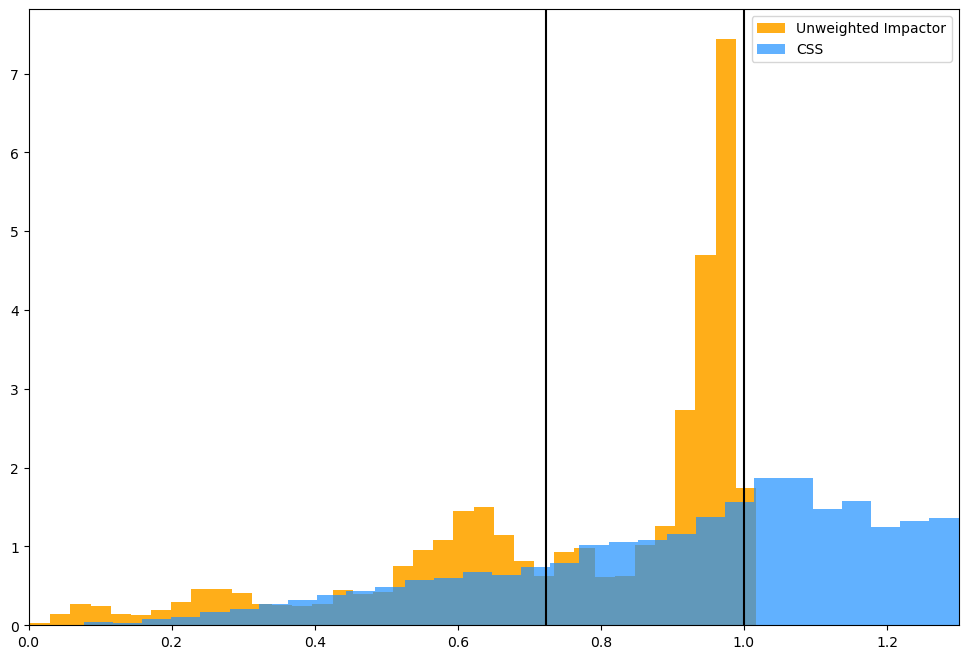

In [10]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat, bins='auto', color = 'orange', label = 'Unweighted Impactor', density=True, alpha=0.9)
plt.hist(mag_limited_qs, bins='auto', color='dodgerblue', label = 'CSS', density=True, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Compare using a K-S test and find the $p$-value:

In [11]:
import scipy.stats
scipy.stats.ks_2samp(impactor_qs_flat, mag_limited_qs).pvalue

0.0

Now compute weights for each of the impactors from their Opik impact probability, given $a$, $e$ and $i$:

Use the same function for collision probability per revolution in the `monte_carlo_granvik_model.ipynb` notebook:

In [12]:
# constants for earth and sun
a0 = 1.  # semi-major axis of earth in au
m = 5.97e24  # mass of earth in kg
R = 4.259e-5  # radius of earth in au
M = 1.988e30  # mass of sun in kg

# get the probability per revolution P
def get_P(a, e, i, a0=a0, m=m, R=R, M=M):
    """
    Get the collision probability per revolution P for an object with semi-major axis a in AU, eccentricity e, and inclination i in degrees
    and a target on a circular orbit with constant semi-major axis a0 in AU, mass m in kg, and radius R in AU, 
    both orbiting a star with mass M in kg

    return: P, the collision probability per revolution
    """
    Q = R/a0  # Q
    Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
    U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U
    tau = Q * np.sqrt(1 + ((2 * m)/(M * Q * (U ** 2))))  # tau
    # tau = R * np.sqrt(1 + R/Q)
    # compute P
    P = ((tau ** 2) * U)/(np.pi * np.sin(np.deg2rad(i)) * np.abs(Ux))
    # return
    return P

Convert the impact probability per revolution $P$ into an impact probability per year $P_t$ :

In [13]:
impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
true_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(true_as, true_es, true_is)])

impactor_pts_flat = impactor_pts.reshape(-1)

/tmp/ipykernel_12935/1632827845.py:17: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_12935/3580413378.py:1: RuntimeWarning: invalid value encountered in power
  impactor_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(impactor_as, impactor_es, impactor_is)])
/tmp/ipykernel_12935/1632827845.py:18: RuntimeWarning: invalid value encountered in sqrt
  U = np.sqrt(3 - (1/a) - ((2 * np.sqrt(a * (1 - e ** 2))) * np.cos(np.deg2rad(i))))  # U


Plot a histogram of the $\log_{10}$ annual impact probability:

(Text(0.5, 0, '$\\log_{10}\\,$impact probability per year'),
 Text(0, 0.5, 'Density'))

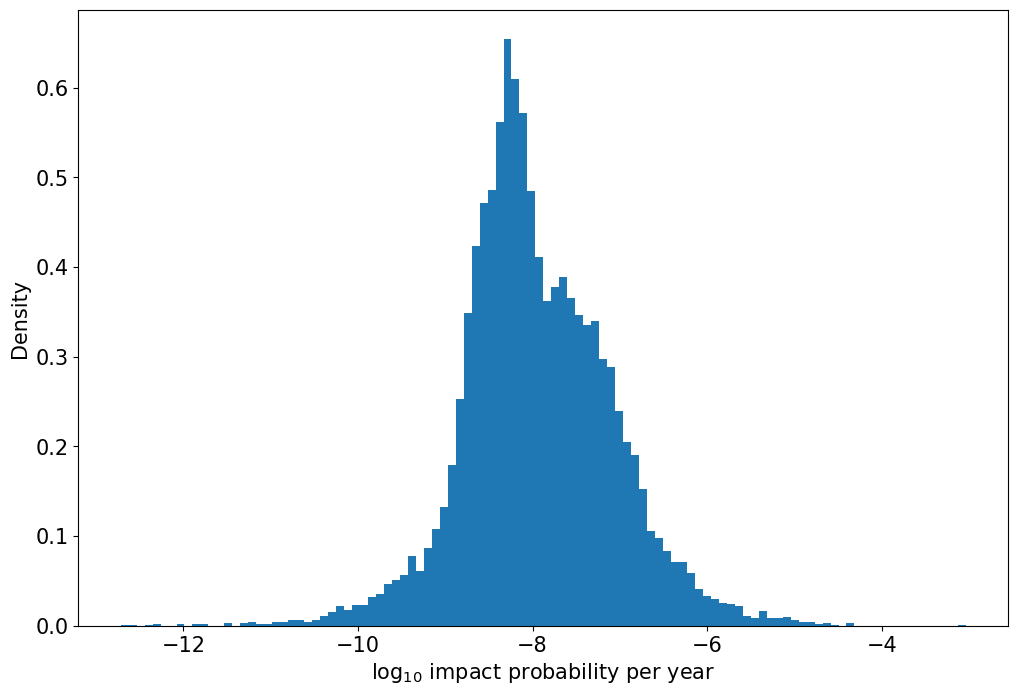

In [14]:
plt.rc('font', size=15)
# convert to lgo to make more readable
plt.figure(figsize = (12, 8))
# plot histogram
plt.hist(np.log10(impactor_pts_flat), bins='auto', density=True)
# label axes
plt.xlabel(r'$\log_{10}\,$impact probability per year'), plt.ylabel('Density')

Eliminate all clones with `nan` annual impact probabilities:

In [15]:
non_nan_mask = ~np.isnan(impactor_pts_flat)  # mask of all non-nan impact probabilities
# filter out nan impact probabilities
impactor_pts_flat_filtered = impactor_pts_flat[non_nan_mask]
impactor_qs_flat_filtered = impactor_qs_flat[non_nan_mask]

# filter out points with too high impact probability (say above 1e-4)
high_impact_prob_mask = impactor_pts_flat_filtered < 1e-4
# impactor_pts_flat_filtered = impactor_pts_flat_filtered[high_impact_prob_mask]
# impactor_qs_flat_filtered = impactor_qs_flat_filtered[high_impact_prob_mask]

(Text(0.5, 0, 'Annual impact probability'), Text(0, 0.5, 'q'))

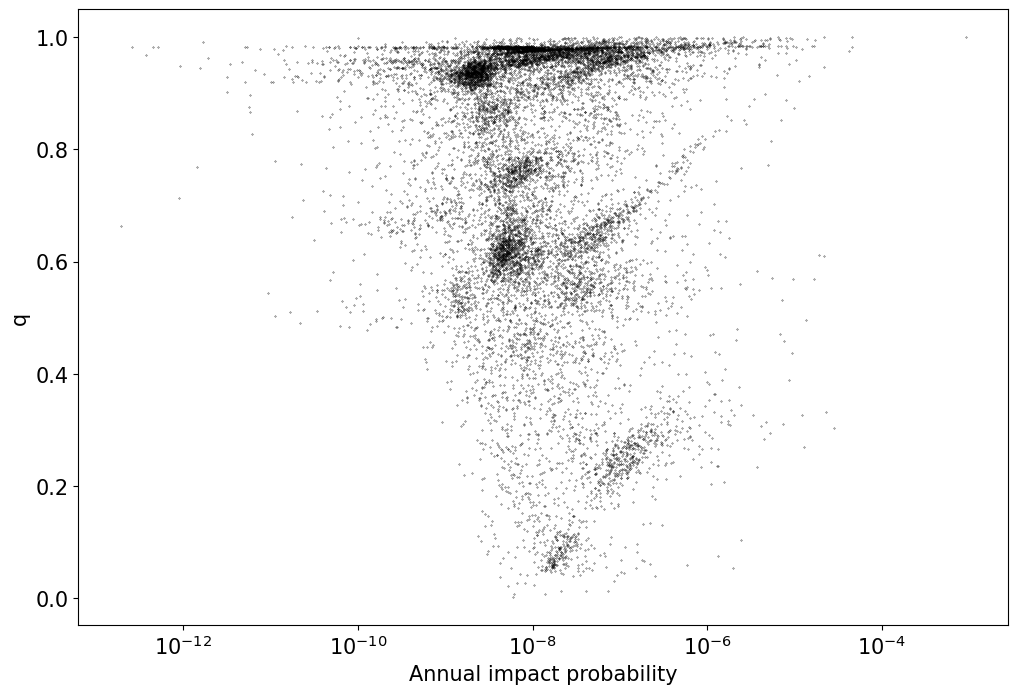

In [16]:
plt.figure(figsize = (12, 8))
plt.scatter(impactor_pts_flat_filtered, impactor_qs_flat_filtered, s=0.07, c='k')
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')

Then plot a histogram comparing the weighted and unweighted $q$ values for the cloned impactors as well as a histogram of the $q$ values for the cloned impactors, weighting by impact probability:

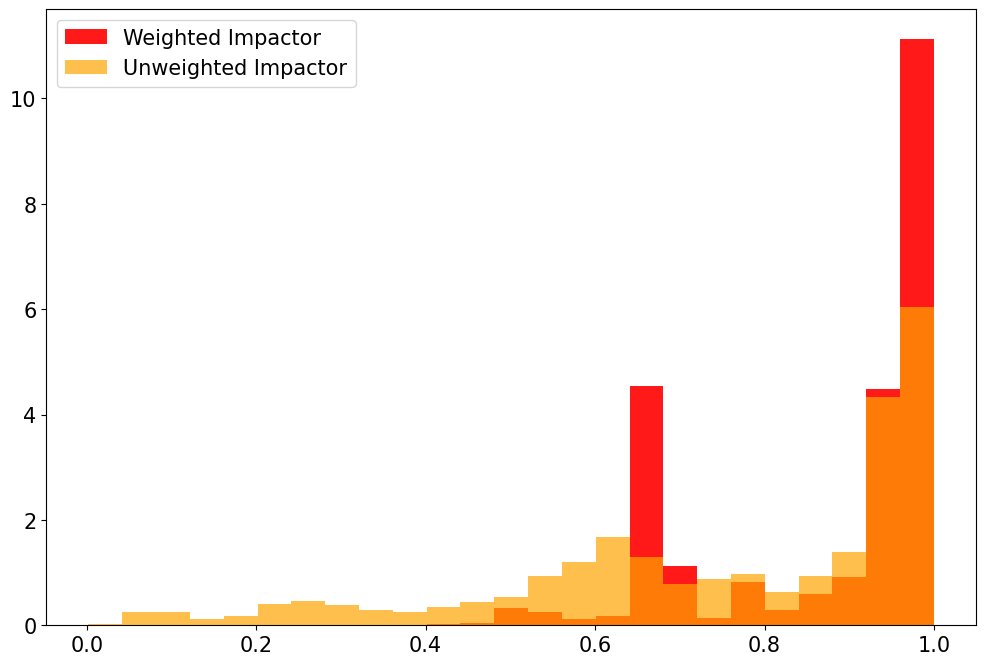

In [17]:
plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'orange', label = 'Unweighted Impactor', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.legend()

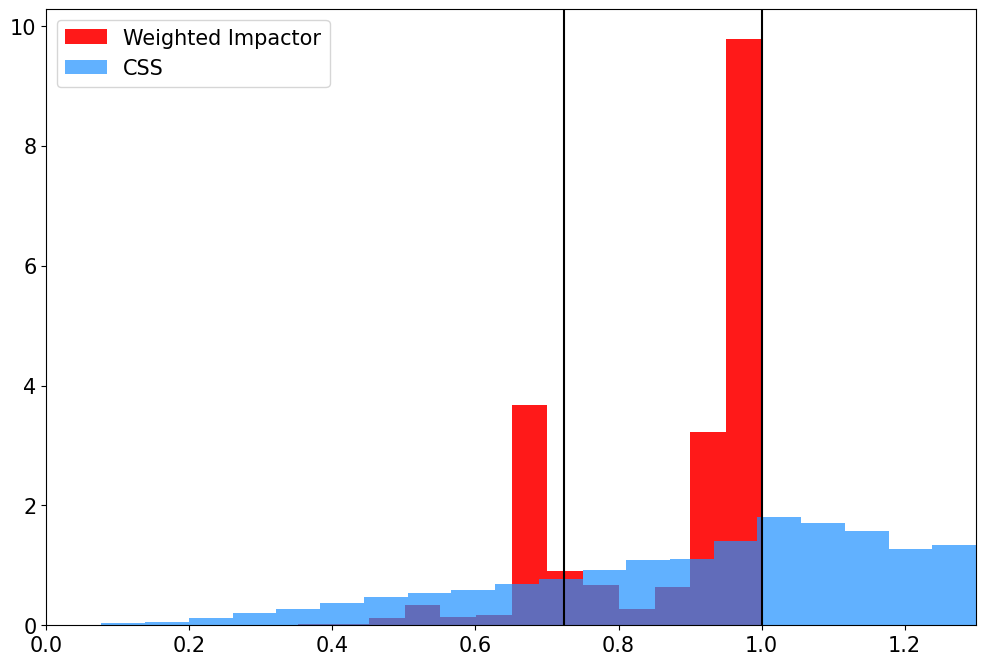

In [18]:
# semi major axes of earth and venus
a_earth = 1.
a_venus = 0.72333199

plt.figure(figsize = (12, 8))
plt.hist(impactor_qs_flat_filtered, bins=20, color = 'red', label = 'Weighted Impactor', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
plt.hist(mag_limited_qs, bins=20, color='dodgerblue', label = 'CSS', density=True, 
         weights=None, alpha=0.7)
# plt.yscale('log')
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')
plt.xlim(left=0., right=1.3)
plt.legend()

Weighted K-S test:

In [19]:
from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob

Computing 1-D K-S test for unweighted and weighted $q$ values and compare unweighted result to default `scipy` K-S test implementation:

In [20]:
print('Unweighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  np.ones(len(impactor_qs_flat_filtered)), np.ones(len(np.array(mag_limited_qs))))) 
print('Weighted:', ks_weighted(impactor_qs_flat_filtered, np.array(mag_limited_qs), 
                  1./impactor_pts_flat_filtered, np.ones(len(np.array(mag_limited_qs)))))

Unweighted: (0.4625920247066627, 0.0)
Weighted: (0.47696974000701087, 0.0)


In [21]:
scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).statistic, scipy.stats.ks_2samp(impactor_qs_flat_filtered, mag_limited_qs).pvalue

(0.4625920247066627, 0.0)

### Comparing to CNEOS fireballs, 824 EN fireballs and the EMCCD Meteors:

Read in all the impactors recorded on the CNEOS website and get the state vectors:

In [22]:
# read in cneos fireballs, dropping row if any of time, latitude, longitude, altitude, vx, vy or vz are nan
cneos_fireballs_raw = pd.read_csv('cneos_fireball_data.csv').dropna(subset=['Peak Brightness Date/Time (UT)', 
                                                                            'Latitude (deg.)', 'Longitude (deg.)', 
                                                                            'Altitude (km)', 'vx', 'vy', 'vz'])
# remove decameter-sized impactors
cneos_fireballs_raw = cneos_fireballs_raw[cneos_fireballs_raw['Calculated Total Impact Energy (kt)'] <= 10.]
# 304 fireballs in total

Convert `vx`, `vy`, `vz` to azimuth, zenith and speed

In [23]:
# rtd is constant
rtd = np.pi/180  # rad/deg
# get time, converting to the format used by pylig: '%Y%m%d-%H%M%S.%f'
t = pd.to_datetime(cneos_fireballs_raw['Peak Brightness Date/Time (UT)'], format='mixed').dt.strftime('%Y%m%d-%H%M%S.%f')
# get elevation
elevation = cneos_fireballs_raw['Altitude (km)']

# get x, y, z velocities, dropping nans
vx, vy, vz = cneos_fireballs_raw.vx, cneos_fireballs_raw.vy, cneos_fireballs_raw.vz
# convert to numerical long, lat, dropping nans
latitude = (cneos_fireballs_raw['Latitude (deg.)'].str[:-1].astype(float) * (2 * (cneos_fireballs_raw['Latitude (deg.)'].str[-1:] == 'N') - 1))
longitude = (cneos_fireballs_raw['Longitude (deg.)'].str[:-1].astype(float) * (2 * (cneos_fireballs_raw['Longitude (deg.)'].str[-1:] == 'E') - 1))

# vx, vy, vz = -10.8, 1.2, -12.8
# latitude = 59.8
# longitude = 16.8

# should get 242.771 azim, 16.6202 zen, 16.7905 speed

# get vn, ve, vd from vx, vy, vz and lat, long
vn = -vx * np.sin(latitude * rtd) * np.cos(longitude * rtd) - vy * np.sin(longitude * rtd) * np.sin(latitude * rtd) + vz * np.cos(latitude * rtd)
ve = -vx * np.sin(longitude * rtd) + vy * np.cos(longitude * rtd)
vd = -vx * np.cos(latitude * rtd) * np.cos(longitude * rtd) - vy * np.cos(latitude * rtd) * np.sin(longitude * rtd) - vz * np.sin(latitude * rtd)
# get azimuth and zenith
azim = np.arctan2(ve, vn)/rtd + 180.  # NOTE that arctan2 in excel is (x, y) but arctan2 in numpy is (y, x)!
zen = np.arctan(np.sqrt(vn ** 2 + ve ** 2)/vd)/rtd
# get total velocity
v = np.sqrt(vx ** 2 + vy ** 2 + vz ** 2)

Define function to convert state vectors to orbital parameters:

In [24]:
import subprocess

# define function to compute orbital parameters from state vectors:
def get_orbital_parameters(state_vector):
    """
    Computes orbital parameters:
    a, e, i, peri, node, M 
    using Pylig, from an iterable state vector packed in the form:
    v, t, lat, lon, el, azim, zen

    a is in AU, i, peri, and node are in degrees
    v is in km/s, t is in the format '%Y%m%d-%H%M%S.%f', lat and lon are in degrees, el is in km, azim and zen are in degrees

    See documentation for 'wmpl.Trajectory.Orbit' for more information on how the computation is done

    param state_vector: iterable containing the state vector in the form specified above to convert to orbital parameters
    return orbital_parameters: array of orbital parameters corresponding to the state vector
    """
    # unpack state vector
    v, t, lat, lon, el, azim, zen = state_vector
    # convert zenith to altitude
    alt = 90 - zen
    # run wmpl to convert state vector to orbit
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v}', '-t', f'{t}', '-a', f'{lat}', 
                             '-o', f'{lon}', '-e', f'{el}', '--azim', f'{azim}', '--alt', f'{alt}', 
                             '--vrotcorr', '--statfixed'], capture_output=True)
    # get orbital parameters from the output in the order specified in the docstring
    orbital_parameters = np.array([np.float64(string) for param in [elem for elem in 
                                                                    list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                                    if elem.startswith(tuple(orb_param_variables))] 
                                   for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
    # return orbital parameters
    return orbital_parameters
    

Optional: Run them through Pylig to get the orbital parameter values, using multiprocessing to parallelize it. This takes about $2$ minutes to run:

In [25]:
# # create list of all ~300 state vectors
# state_vector_list = list(np.array([v, t, latitude, longitude, elevation, azim, zen]).T)

# # compute orbital parameters using multiprocessing
# pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
# # compute the orbital parameters using multiprocessing and save them to an array
# # discard empty arrays as sometimes WMPL fails to return anything
# orb_param_array = np.array([x for x in list(tqdm(pool.imap(get_orbital_parameters, state_vector_list), total=len(state_vector_list))) if x.size])

Optional: Save file as Numpy array:

In [26]:
# np.save('orb_param_array_all_cneos_fireballs.npy', orb_param_array)  # save as a .npy file

Optional: Load file:

In [27]:
orb_param_array = np.load('orb_param_array_all_cneos_fireballs.npy')  # load .npy file

Now read in the $824$ EN fireballs from Borovicka et al. 2022 as well as the EMCCD data:

In [28]:
# Read in EN fireballs

en_fireballs = pd.read_fwf('catalog.dat', header=None).drop(columns=[81, 85]) # drop column 81 as well since it's having trouble reading phaethon
en_fireballs.columns = ['code', 'obs_date', 'obs_time', 'e_obs_time', 'jd', 
                        'lsun', 'lam-beg', 'phi-beg', 'h-beg', 'lam-end', 
                        'phi-end', 'h-end', 'lam-avg', 'phi-avg', 'h-avg', 
                        'lam-max', 'phi-max', 'h-max', 'length', 'dur', 
                        'azim', 'zendis', 'radeg', 'e_radeg', 'dedeg', 
                        'e_dedeg', 'vinf', 'e_vinf', 'vmax', 'vter', 
                        'hvter', 'rageo', 'e_rageo', 'degeo', 'e_degeo', 
                        'lgeo-lsun', 'bgeo', 'vgeo', 'e_vgeo', 'lhel', 
                        'e_lhel', 'bhel', 'e_bhel', 'vhel', 'e_vhel', 
                        'ax', 'e_ax', 'ecc', 'e_ecc', 'perih', 
                        'e_perih', 'aph', 'e_aph', 'inc', 'e_inc', 
                        'omg', 'e_omg', 'nod', 'e_nod', 'lper', 
                        'e_lper', 'tyear', 'tmonth', 'tday', 'e_tday', 
                        'per', 'e_per', 'tiss', 'e_tiss', 'mag', 
                        'energy', 'mass', 'termass', 'pe', 'type', 
                        'pres', 'hpres', 'pf', 'pf-class', 'shower', 
                        'object', 'ncam', 'mindist', 'spectrum']

# Read in EMCCD data

# import kb_and_kc_calc
# emccd_meteors = kb_and_kc_calc.extract_from_table()
emccd_meteors = pd.read_json('solution_table.json')

Get the $a$, $e$, $i$, $q$ values and perform the same impact probability weighting for the CNEOS fireballs, EN fireballs and the EMCCD data:

In [29]:
# get a, e, i, q for CNEOS, EN and EMCCD fireballs
cneos_as, cneos_es, cneos_is, cneos_peris, cneos_nodes, cneos_Ms = orb_param_array.T
cneos_qs = cneos_as * (1. - cneos_es)
en_as, en_es, en_is, en_qs = np.array(en_fireballs[['ax', 'ecc', 'inc', 'perih']]).T
emccd_as, emccd_es, emccd_is, emccd_qs = np.array(emccd_meteors[['a', 'e', 'i', 'q']]).T

# and get the EN annual impact probabilities
en_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(en_as, en_es, en_is)])
emccd_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(emccd_as, emccd_es, emccd_is)])
cneos_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(cneos_as, cneos_es, cneos_is)])

/tmp/ipykernel_12935/4193646431.py:8: RuntimeWarning: invalid value encountered in scalar power
  en_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(en_as, en_es, en_is)])
/tmp/ipykernel_12935/1632827845.py:17: RuntimeWarning: invalid value encountered in sqrt
  Ux = np.sqrt(2 - (1/a) - (a * (1 - (e ** 2))))  # Ux
/tmp/ipykernel_12935/4193646431.py:9: RuntimeWarning: invalid value encountered in scalar power
  emccd_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(emccd_as, emccd_es, emccd_is)])
/tmp/ipykernel_12935/4193646431.py:10: RuntimeWarning: invalid value encountered in scalar power
  cneos_pts = np.array([get_P(a, e, i)/(a ** (3./2.)) for a, e, i in zip(cneos_as, cneos_es, cneos_is)])


Plot probabilities:

In [30]:
i = 0
en_as[i] * (1. - (en_es[i])), en_as[i], en_es[i], en_is[i], en_qs[i]

(0.9653027999999986, 28.644, 0.9663, 113.08, 0.9656)

In [31]:
emccd_as[i] * (1. - (emccd_es[i])), emccd_as[i], emccd_es[i], emccd_is[i], emccd_qs[i]

(0.6434241307398988,
 -35.889931895722974,
 1.017927705536175,
 22.999065868470193,
 0.643424130739914)

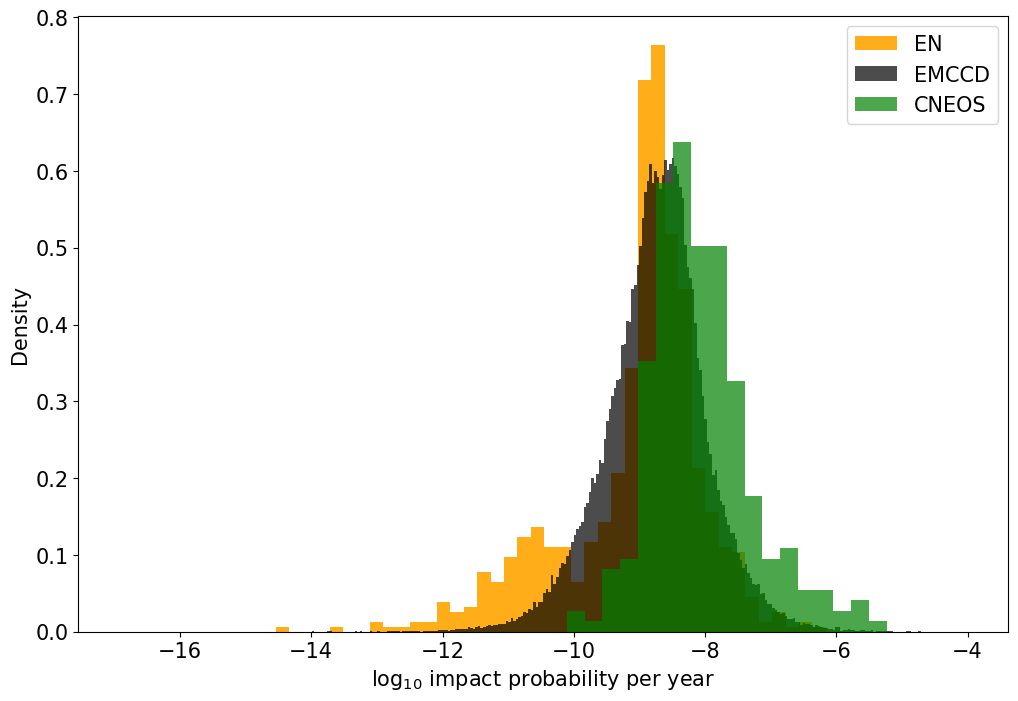

In [32]:
plt.rc('font', size=15)
# convert to lgo to make more readable
plt.figure(figsize = (12, 8))
# plot histogram
plt.hist(np.log10(en_pts), bins='auto', density=True, label = 'EN', color='orange', alpha=0.9)
plt.hist(np.log10(emccd_pts), bins='auto', density=True, label = 'EMCCD', color='black', alpha=0.7)
plt.hist(np.log10(cneos_pts), bins='auto', density=True, label = 'CNEOS', color='green', alpha=0.7)
# label axes
plt.xlabel(r'$\log_{10}\,$impact probability per year'), plt.ylabel('Density')
plt.legend()

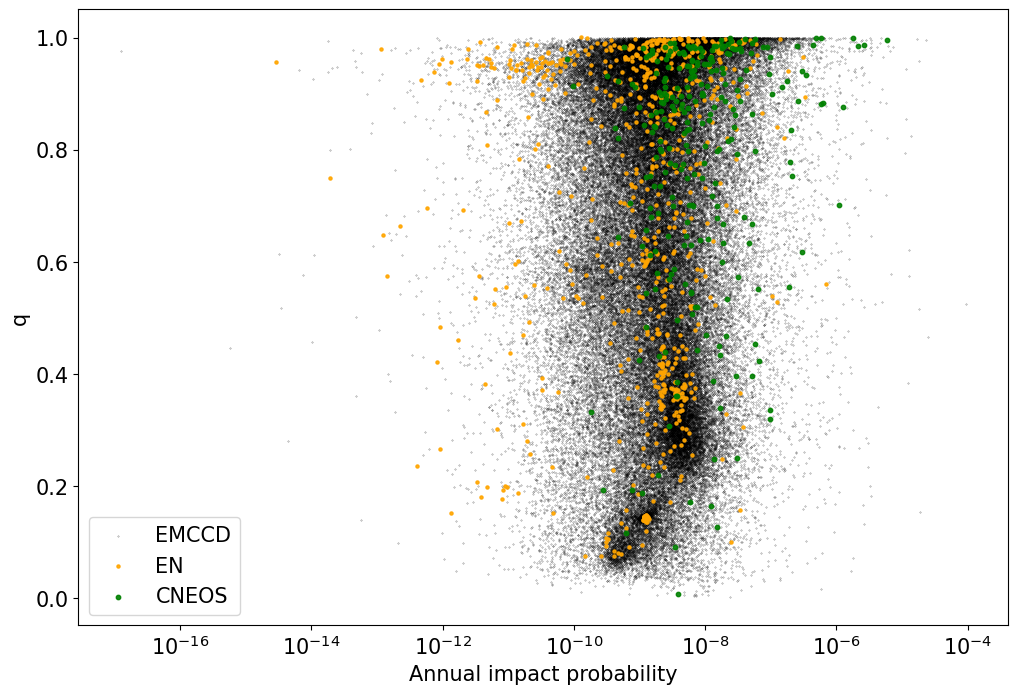

In [33]:
plt.figure(figsize = (12, 8))
plt.scatter(emccd_pts, emccd_qs, s=0.07, c='black', label = 'EMCCD', alpha=0.6)
plt.scatter(en_pts, en_qs, s=5, c='orange', label = 'EN', alpha=0.9)
plt.scatter(cneos_pts, cneos_qs, s=10., c='green', label = 'CNEOS', alpha = 0.9)
plt.xscale('log')
plt.xlabel('Annual impact probability'), plt.ylabel('q')
plt.legend()

Filter `nan` impact probability values for all of the CNEOS, EN and EMCCCD fireballs:

In [34]:
cneos_non_nan_mask = ~np.isnan(cneos_pts)
en_non_nan_mask = ~np.isnan(en_pts)  # mask of all non-nan impact probabilities
emccd_non_nan_mask = ~np.isnan(emccd_pts)

# filter out nan impact probabilities
cneos_pts_filtered = cneos_pts[cneos_non_nan_mask]
cneos_qs_filtered = cneos_qs[cneos_non_nan_mask]

en_pts_filtered = en_pts[en_non_nan_mask]
en_qs_filtered = en_qs[en_non_nan_mask]

emccd_pts_filtered = emccd_pts[emccd_non_nan_mask]
emccd_qs_filtered = emccd_qs[emccd_non_nan_mask]

And plot a histogram of the CSS observations against the weighted decameter impactors, weighted CNEOS fireballs, weighted EN fireballs, weighted EMCCD meteors

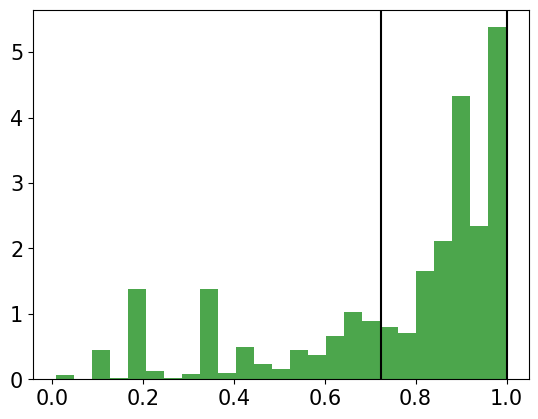

In [35]:
plt.hist(cneos_qs_filtered, bins=25, color='green', label = 'Weighted CNEOS', density=True, 
         weights=1./cneos_pts_filtered, alpha=0.7)
plt.axvline(a_earth, color='k')
plt.axvline(a_venus, color='k')

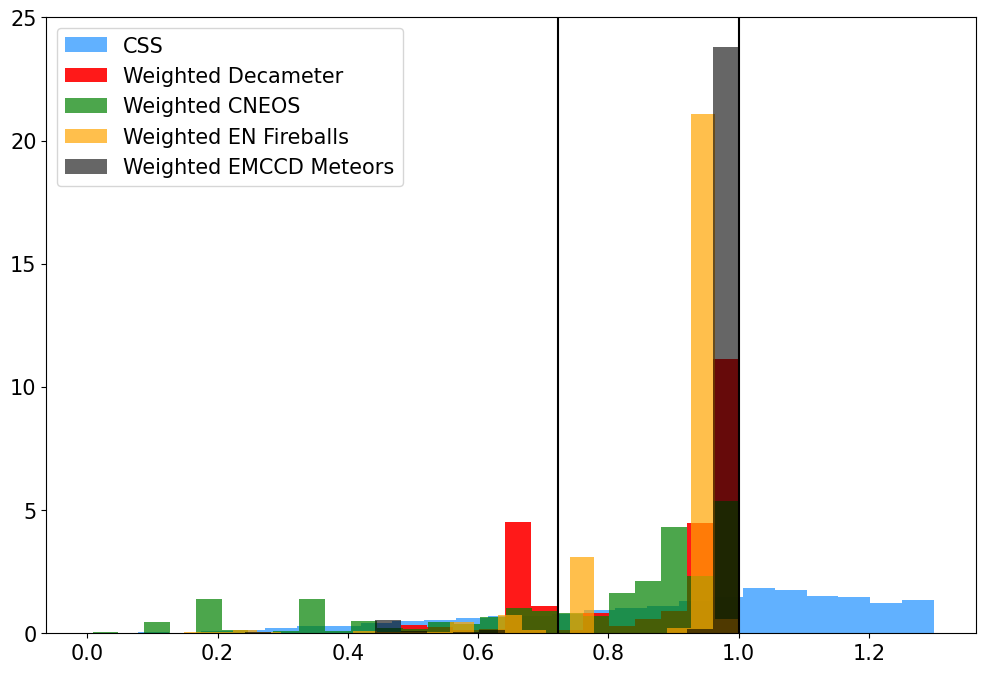

In [36]:
plt.figure(figsize = (12, 8))
# CSS
plt.hist(mag_limited_qs, bins=25, color='dodgerblue', label = 'CSS', density=True, 
         weights=None, alpha=0.7)
# Decameter impactors
plt.hist(impactor_qs_flat_filtered, bins=25, color = 'red', label = 'Weighted Decameter', density=True, 
         weights=1./impactor_pts_flat_filtered, alpha=0.9)
# CNEOS Fireballs

plt.hist(cneos_qs_filtered, bins=25, color='green', label = 'Weighted CNEOS', density=True, 
         weights=1./cneos_pts_filtered, alpha=0.7)
# EN Fireballs
# plt.hist(en_qs[en_non_nan_mask], bins=25, color='green', label = 'Unweighted EN Fireballs', density=True, alpha=0.7)
plt.hist(en_qs_filtered, bins=25, color = 'orange', label = 'Weighted EN Fireballs', density=True, 
         weights=1./en_pts_filtered, alpha=0.7)
# EMCCD Meteors
# plt.hist(emccd_qs[emccd_non_nan_mask], bins=25, color='green', label = 'Unweighted EMCCD Meteors', density=True)
plt.hist(emccd_qs_filtered, bins=25, color = 'black', label = 'Weighted EMCCD Meteors', density=True, 
         weights=1./emccd_pts_filtered, alpha=0.6)

# plt.yscale('log')
plt.legend()
plt.axvline(a_earth, color = 'k')
plt.axvline(a_venus, color = 'k')